# summary data 
- record 04015 ([1:8])
- record 04043 ([1:16])
- record 04048 ([1:6])
- record 04126 ([1:])
- record 04746 (tidak di proses, karena kebanyakan data N)
- record 04908 ([1:]) -> annotate.txt nya di custom
- record 04936 ([4:])
- record 05091 ([1:])
- record 05121 ([1:])
- record 05261 ([1:18])
- record 06426 ([1:])
- record 06453 ([1:])
- record 06995 ([1:])
- record 07162 (tidak di proses, isinya hanya AF)
- record 07859 (tidak di proses, isinya hanya AF)
- record 07879 (tidak di proses, karena kebanyakan data N)
- record 07910 ([1:10])
- record 08215 ([1:])
- record 08219 ([1:])
- record 08378 ([5:])
- record 08405 (tidak di proses, karena kebanyakan data N)
- record 08434 (tidak di proses, karena semua data N)
- record 08455 ([1:])

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
record = "04015"

In [3]:
dataset_dir = "dataset/AFDB record_%s/" % record

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)

___
# 1. Load Dataset
- Read Annotation file

In [4]:
file = open(dataset_dir + 'annotation.txt',"r") 
annotations = file.readlines()
file.close()

In [5]:
label_idx = []
for item in annotations[1:8] :
    item_split = item.split()
    label_idx.append([item_split[0].replace("[", "").replace("]", ""), item_split[-1].replace("(", "")])

In [6]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

- Read & formatting ECG data

In [7]:
def read_csv_to_df(filename, folder, sep=";"):
    df = pd.read_csv(folder + filename, sep=sep)
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG1', 'ECG2']

    df['ECG1'] = pd.to_numeric(df['ECG1'])
    df['ECG2'] = pd.to_numeric(df['ECG2'])
    
    # peak reduction
    df[df['ECG1'] > 2] = 2
    df[df['ECG1'] < -2] = -2
    df[df['ECG2'] > 2] = 2
    df[df['ECG2'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

In [8]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [9]:
df_ecg.head()

ECG1   ECG2
Time                                 
2021-07-17 09:00:00.000 -0.275 -0.210
2021-07-17 09:00:00.004 -0.295 -0.200
2021-07-17 09:00:00.008 -0.310 -0.220
2021-07-17 09:00:00.012 -0.315 -0.225
2021-07-17 09:00:00.016 -0.300 -0.215

- plot signal 

In [10]:
def plot_signal(data, fs, label="ECG sample raw data"):
    ecg1 = data['ECG1'].values
    ecg2 = data['ECG2'].values

    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, ecg1, '#1f77b4')
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.grid(True)
    plt.ylim([-2.1, 2.1])
    plt.legend(["channel 1"])
    
    plt.subplot(2, 1, 2)
    plt.plot(times, ecg2, '#ff7f0e')
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.grid(True)
    plt.ylim([-2.1, 2.1])
    plt.legend(["channel 2"])
    
    plt.show()

In [11]:
fs = 250 #hz

09:00:00 09:00:16


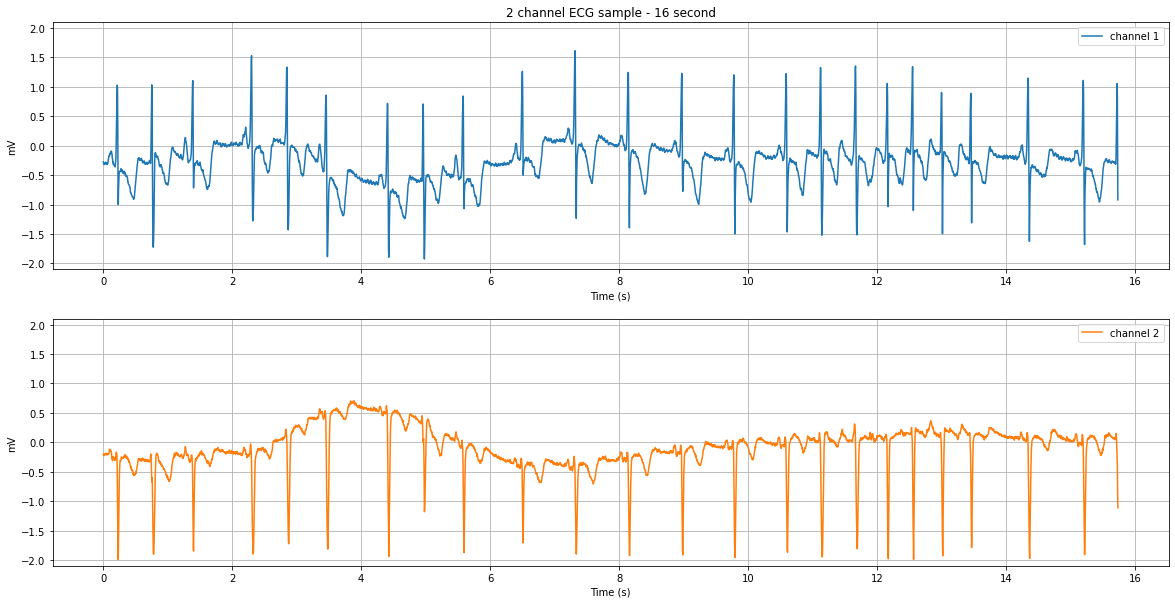

In [12]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "2 channel ECG sample - 16 second")

___
# 2. Split Dataset per-16s sequece & Apply Baseline Wander Removal

- Split Normal (N) and AFIB data

In [13]:
label_idx

[['09:00:00.120', 'N'],
 ['09:06:50.336', 'AFIB'],
 ['09:07:58.416', 'N'],
 ['09:08:07.092', 'AFIB'],
 ['09:08:08.776', 'N'],
 ['09:08:53.392', 'AFIB'],
 ['09:11:07.428', 'N']]

In [14]:
N_range = []
AFIB_range = []

for i in range(len(label_idx) - 1):
    tm_str = label_idx[i][0]
    next_tm_str = label_idx[i + 1][0]
    tm = pd.to_datetime(tm_str)
    next_tm = pd.to_datetime(next_tm_str)
    
    if label_idx[i][1] == 'N' :
        N_range.append([tm, next_tm])
    else :
        AFIB_range.append([tm, next_tm])

In [15]:
AFIB_range

[[Timestamp('2021-07-17 09:06:50.336000'),
  Timestamp('2021-07-17 09:07:58.416000')],
 [Timestamp('2021-07-17 09:08:07.092000'),
  Timestamp('2021-07-17 09:08:08.776000')],
 [Timestamp('2021-07-17 09:08:53.392000'),
  Timestamp('2021-07-17 09:11:07.428000')]]

In [16]:
N = []
for nr in N_range :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    N.append(result)

In [17]:
AFIB = []
for ar in AFIB_range :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    AFIB.append(result)

- Save splitted CSV

In [18]:
if not os.path.exists("dataset_split_per_class"):
    os.mkdir("dataset_split_per_class")

In [19]:
N = []
for ix, nr in enumerate(N_range) :
    result = df_ecg.between_time(nr[0].time(), nr[1].time())
    result.to_csv("dataset_split_per_class/%s_%s_%s_%s.csv" % 
                  ('N', record, 'ECG1', ix))
    N.append(result)


In [20]:
AFIB = []
for ix, ar in enumerate(AFIB_range) :
    result = df_ecg.between_time(ar[0].time(), ar[1].time())
    result.to_csv("dataset_split_per_class/%s_%s_%s_%s.csv" % 
                  ('AF', record, 'ECG1', ix))
    AFIB.append(result)

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [21]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [22]:
def plot_16s_sample(data, label="2 channel ECG plot - 16s sample", y_label = 'mV'):
    ecg1 = data[0]
    ecg2 = data[1]
    
    times = np.arange(ecg1.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 10))
    plt.subplot(2,1,1)
    plt.plot(times, ecg1, '#1f77b4')
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["channel 2"])
    plt.grid(True)
    
    plt.subplot(2,1,2)
    plt.plot(times, ecg2, '#ff7f0e')
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(["channel 2"])
    plt.grid(True)
    
    plt.show()

In [23]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [24]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [25]:
time_interval_N = []
for N_item in N:
    intr = [time_result for time_result in perdelta(N_item.index[0], N_item.index[-1], timedelta(seconds=16))]
    time_interval_N.append(intr)

In [26]:
time_interval_AFIB = []
for AFIB_item in AFIB:
    intr = [time_result for time_result in perdelta(AFIB_item.index[0], AFIB_item.index[-1], timedelta(seconds=16))]
    time_interval_AFIB.append(intr)

In [27]:
ECG_ALS = []
ECG_ALS_label = []

for time_interval in time_interval_N :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('N')
        
for time_interval in time_interval_AFIB :
    for time_intv in list(zip(time_interval, time_interval[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        ecg1 = X['ECG1'].values
        ecg2 = X['ECG2'].values
        
        if len(ecg1) > 0 and len(ecg2) > 0:
            ALS1 = ecg1 - baseline_als(ecg1)
            ALS2 = ecg2 - baseline_als(ecg2)

            ECG_ALS.append(np.array([ALS1, ALS2]))
            ECG_ALS_label.append('AF')

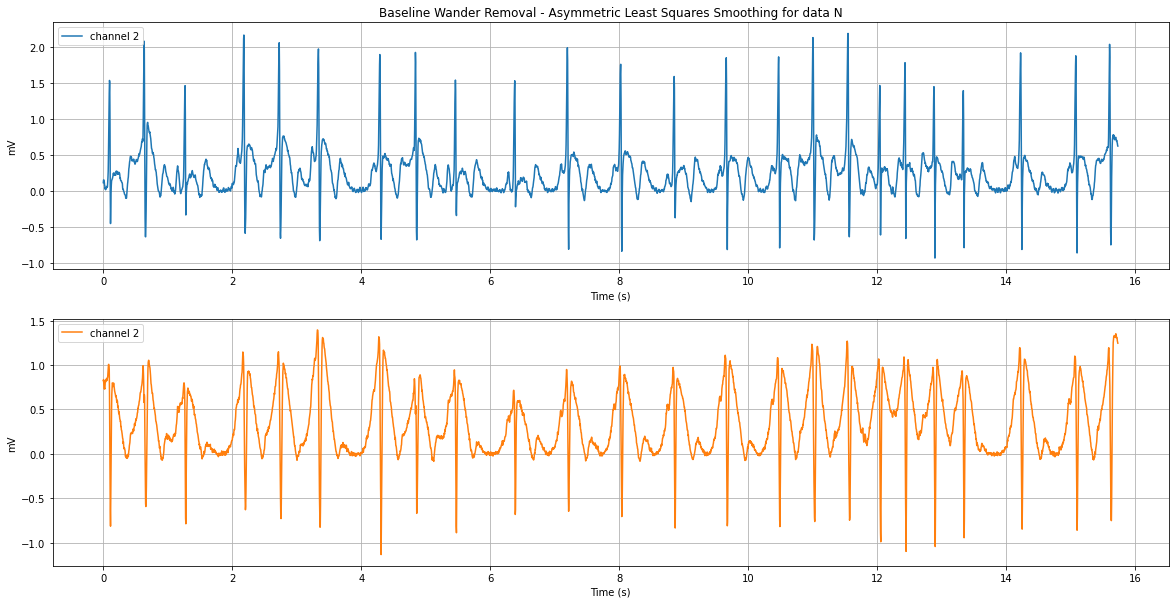

In [28]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

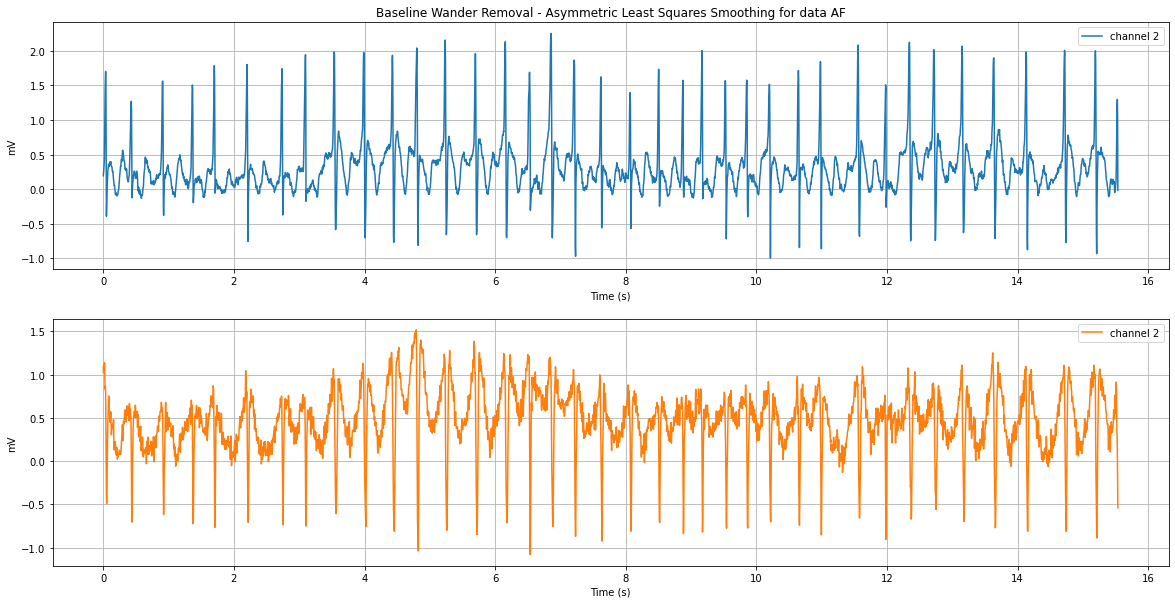

In [34]:
idx = -1
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

___
# 3. Signal Normalization
- Signal normalization from -1 to 1

In [31]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [32]:
scaler = MaxAbsScaler()

ECG_ALS_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_ALS_Norm.append([als_norm1, als_norm2])

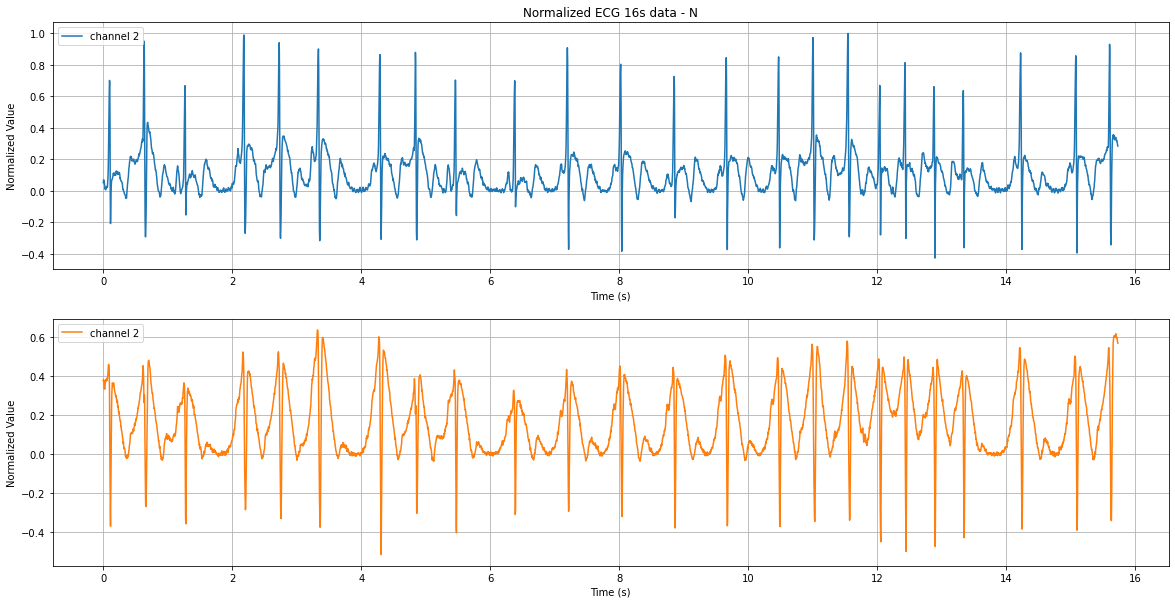

In [33]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

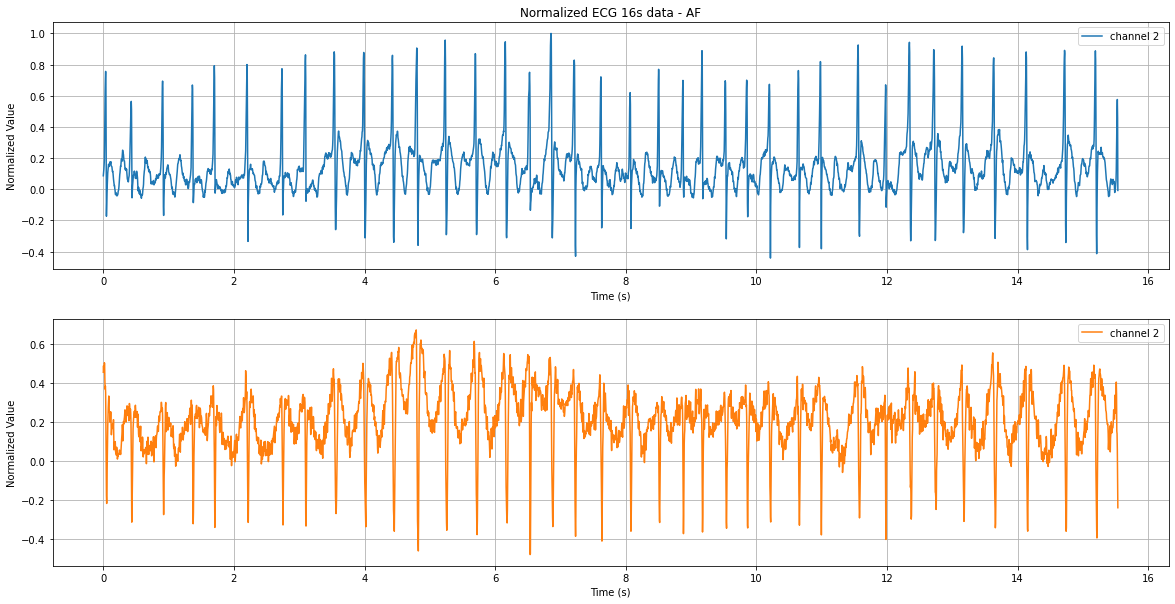

In [35]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

# 4. Save Signal Sequence per-16s Data 

In [320]:
data = []
pad_size = 4000 # 16s x 250hz
for i in range(len(ECG_ALS_Norm)):
    signal_ch = []
    for ch in [0, 1] :
        signal = np.array(ECG_ALS_Norm[i])[ch, :, 0]
        n = len(signal) if len(signal) <= pad_size else pad_size
        pad = np.zeros(pad_size)
        pad[0:n] = signal[0:n] 
        signal_ch.extend(list(pad))    
    signal_ch.append(ECG_ALS_label[i])
    data.append(signal_ch)

In [321]:
ECG = pd.DataFrame(data)

In [322]:
ECG.head()

0         1         2         3         4         5         6     \
0  0.050815  0.067650  0.068464  0.060125  0.051783  0.031996  0.030512   
1  0.156789  0.160303  0.163816  0.155653  0.156824  0.157988  0.140461   
2  0.267174  0.268143  0.266845  0.276867  0.266500  0.267442  0.275157   
3  0.135501  0.145561  0.155620  0.161292  0.164767  0.161657  0.154151   
4  0.260396  0.263330  0.273367  0.283401  0.286322  0.308174  0.325270   

       7         8         9     ...  7991  7992  7993  7994  7995  7996  \
0  0.010714  0.018370  0.005420  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.125253  0.124031  0.106438  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.273786  0.270113  0.291302  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.148822  0.154435  0.155635  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.318657  0.321478  0.321881  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   7997  7998  7999  8000  
0   0.0   0.0   0.0     N  
1   0.0   0.0   0.0     N  
2   0.0   0.0   0.0     N  
3   0.0   0.0   0.0     N  
4   0.0   0.0   0.0     N  

[5 rows x 8001 columns]

In [323]:
# save Signal Sequence 16s 

ECG.to_csv("dataset/AFDB_%s_sequence_16s_2_ch.csv" % record, index=False, header=False)